<a href="https://colab.research.google.com/github/Shifath472533/All-Image-captioning-models-and-links-for-data-sets-in-Bangla/blob/master/ResNet_Bangla_(Machine_Translated)_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Mounting <b>google drive</b></h3>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Setting up <b>dependencies</b></h3>

In [4]:
!pip install --upgrade pip
!pip install pycocotools
!pip install git+https://github.com/salaniz/pycocoevalcap          #this is for pycocoevalcap library to calulate metrics
!pip install git+https://github.com/Maluuba/nlg-eval.git@master    #this is for nlgeval library to calulate metrics
!nlg-eval --setup

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-e015m_su
  Running command git clone -q https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-e015m_su
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.1-py3-none-any.whl size=104310172 sha256=0bd881a98ee2d2ae2e90f6d42b353883072c429693157ee12eb6b8ab12c258d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-zla0ew_i/wheels/df/74/69/758b2491ca93bf681a1509671df34df9cf5ff605edf6e112ed
Successfully built pycocoevalcap
  Cloning https://github.com/Maluuba/nlg-eval.git (to revision master) to /tmp/pip-req-build-87_n0mz9
  Running command git clone -q https://github.com/Maluuba/nlg-eval.git /tmp/pip-req-build-87_n0mz9
  Created wheel for nlg-eval: filename=nlg_eval-2.3-py3-none-any.whl size=68175137 sha256=12d26822e21bcb73d6d2688d353488389e59008b0c3669397cc3040d94cec9b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing <b>Libraries</b></h3>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from numpy import array
import pickle
import numpy as np
import os
import cv2

Using TensorFlow backend.


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing Libraries for <b>pycocoevalcap</b></h3>

In [0]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing Libraries for <b>nlgeval</b></h3>

In [0]:
from __future__ import unicode_literals
import os
import unittest
import nlgeval
from nlgeval import NLGEval

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading **image directory** and counting the <b>No. of images</b></h3>

In [0]:
cap_per_img = {}
defected_cap = {}

In [9]:
cnt_img = 0
#image directory
img_dir = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flicker8k_Dataset"

for filename in os.listdir(img_dir):
  cap_per_img[filename] = []
  defected_cap[filename] = []
  cnt_img+=1
    
print("Number of images : " , cnt_img)
print("Number of captions should be : " , cnt_img*5)

Number of images :  8091
Number of captions should be :  40455


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Checking If captions are defected and print if it is with Image names</h3>

In [10]:
token_dir = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr8k_bangla.token.txt"

cnt_cap = 0

with open (token_dir, "r",encoding="utf-16") as fileHandler:
        for line in fileHandler:
            sentence = line.strip()
            sentences = sentence.split("\t")
            ans = sentences[0]
            ans1 = ans.split("#")
            # print(ans1[0] , " : ",ans1[1])
            if ans1[0] in cap_per_img:
              cap_per_img[ans1[0]].append(ans1[1])
              cnt_cap+=1
            else:
              defected_cap[ans1[0]].append(ans1[1])

if(cnt_img*5 == cnt_cap):
  print("All captions are okay.")
elif(len(defected_cap) > 0):
  print("Defected captions : ")
  for img_nm in defected_cap:
    print("Image Name : ",img_nm,"  Number : ",defected_cap[img_nm])          


All captions are okay.


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Loading the directories of **token.csv** , **train.txt** , **test.txt** and **validation.txt** files and converting them to pandas &nbsp;&nbsp;dataframe</h3>

In [0]:
image_tokens=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr8k_bangla.token.txt", encoding = "utf-16",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr_8k.trainImages.txt",encoding = "utf-16",names=["img_id"])
test_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr_8k.testImages.txt",encoding = "utf-16",names=["img_id"])
val_image_names=pd.read_csv("/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/Flickr_8k.devImages.txt",encoding = "utf-16",names=["img_id"])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>image_tokens</b></h3>

In [12]:
image_tokens.head(5)

,img_id,img_caption
0,1000268201_693b08cb0e.jpg#0,গোলাপী পোশাকে একটি শিশু প্রবেশের পথে সিঁড়ির এ...
1,1000268201_693b08cb0e.jpg#1,একটি মেয়ে কাঠের ভবনে .ুকছে।
2,1000268201_693b08cb0e.jpg#2,একটি ছোট্ট মেয়ে কাঠের প্লে হাউসে উঠছে।
3,1000268201_693b08cb0e.jpg#3,একটি ছোট্ট মেয়ে সিঁড়ি বেয়ে তার প্লে হাউসে উ...
4,1000268201_693b08cb0e.jpg#4,গোলাপী পোশাকের একটি ছোট্ট মেয়ে কাঠের কেবিনে ....


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>train image names</b></h3>

In [13]:
train_image_names.head(5)

,img_id
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg
3,488416045_1c6d903fe0.jpg
4,2644326817_8f45080b87.jpg


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing one of the <b>train images</b></h3>

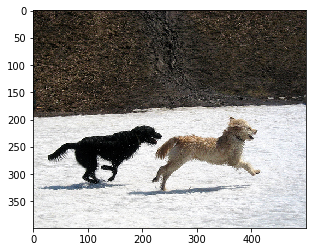

In [14]:
img=cv2.imread(img_dir+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Removing the #0 , #1 #2 , #3 , #4 from the <b>image ids</b></h3>

In [0]:
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>image_tokens</b> again</h3>

In [16]:
image_tokens.head(5)

,img_id,img_caption
0,1000268201_693b08cb0e.jpg,গোলাপী পোশাকে একটি শিশু প্রবেশের পথে সিঁড়ির এ...
1,1000268201_693b08cb0e.jpg,একটি মেয়ে কাঠের ভবনে .ুকছে।
2,1000268201_693b08cb0e.jpg,একটি ছোট্ট মেয়ে কাঠের প্লে হাউসে উঠছে।
3,1000268201_693b08cb0e.jpg,একটি ছোট্ট মেয়ে সিঁড়ি বেয়ে তার প্লে হাউসে উ...
4,1000268201_693b08cb0e.jpg,গোলাপী পোশাকের একটি ছোট্ট মেয়ে কাঠের কেবিনে ....


In [0]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: str(x))

In [0]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Visualizing the <b>image_tokens</b> again with <b>`<start>`</b> and <b>`<end>`</b> </h3>

In [19]:
image_tokens.head()

,img_id,img_caption
0,1000268201_693b08cb0e.jpg,<start> গোলাপী পোশাকে একটি শিশু প্রবেশের পথে স...
1,1000268201_693b08cb0e.jpg,<start> একটি মেয়ে কাঠের ভবনে .ুকছে। <end>
2,1000268201_693b08cb0e.jpg,<start> একটি ছোট্ট মেয়ে কাঠের প্লে হাউসে উঠছে...
3,1000268201_693b08cb0e.jpg,<start> একটি ছোট্ট মেয়ে সিঁড়ি বেয়ে তার প্লে...
4,1000268201_693b08cb0e.jpg,<start> গোলাপী পোশাকের একটি ছোট্ট মেয়ে কাঠের ...


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating **train dictionary** having key as the image id and value as a list of its captions</h3>

In [20]:
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:19<00:00, 315.60it/s]


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating **test dictionary** having key as the image id and value as a list of its captions</h3>

In [21]:
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 307.11it/s]


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating **validation dictionary** having key as the image id and value as a list of its captions</h3>

In [22]:
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 310.41it/s]


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing the **ResNet50** model and printing the <b>summary</b></h3>

In [23]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()













94658560/94653016 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining the path to save the <b>pickle file</b></h3>

In [0]:
pickle_path = "/content/drive/My Drive/Automatic Image Captioning - 350 (2016331001,2016331011)/Flickr8k/"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Extracting image encodings(features) from **ResNet50** and forming dict **train_features** and encoding as a <b>pkl</b> &nbsp;&nbsp;file</h3>

In [0]:
path=img_dir+"/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

 22%|██▏       | 1334/6000 [12:45<49:25,  1.57it/s]

In [0]:
print("After Extracting Features length of train_features : ")
print(len(train_features))

In [0]:
with open( pickle_path+"encoded_train_images_machine_translated.pkl", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [0]:
train_features = {}
pickle_in = open(pickle_path + "encoded_train_images_machine_translated.pkl","rb")
train_features = pickle.load(pickle_in)

In [26]:
print("After Extracting from pkl file length of train_features : ")
print(len(train_features))

After Extracting from pkl file length of train_features : 
1000


<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Extracting image encodings(features) from **ResNet50** and forming dict <b>test_features</b> and encoding as a <b>pkl</b> &nbsp;&nbsp;file</h3>

In [0]:
path=img_dir+"/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

In [0]:
with open( pickle_path+"encoded_train_images_machine_translated.pkl", "wb" ) as pickle_f1:
    pickle.dump(test_features, pickle_f1 )

In [0]:
test_features = {}
pickle_in = open(pickle_path + "encoded_train_images_machine_translated.pkl","rb")
test_features = pickle.load(pickle_in)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Extracting image encodings(features) from **ResNet50** and forming dict <b>validation_features</b> and encoding as a <b>&nbsp;&nbsp;pkl</b> file</h3>

In [0]:
path=img_dir+"/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

In [0]:
with open( pickle_path+"encoded_validation_images_machine_translated.pkl", "wb" ) as pickle_f2:
    pickle.dump(validation_features, pickle_f2 )

In [0]:
validation_features = {}
pickle_in = open(pickle_path + "encoded_validation_images_machine_translated.pkl","rb")
validation_features = pickle.load(pickle_in)

In [0]:
print(train_captions)

In [0]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(str(captions))

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

In [0]:
x = all_captions[14381]
print(x)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining **max_length** and **vocabulary size**</h3>

In [0]:
vocab_size=len(unique_words)+1
max_length=40

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Forming dictionaries containg mapping of **words to indices** and <b>indices to words</b></h3>

In [0]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Forming dictionary having <b>encoded captions</b></h3>

In [0]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    print(img_id)
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

In [0]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

In [0]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(2):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Importing **Libraries**</h3>

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining <b>Model</b> for generating captions</h3>

In [0]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
#lstm_1=LSTM(256)(dropout_2)

#changes done to integrate 1D- Convolutional layer
conv_1D = Conv1D(filters=256, kernel_size=3, activation='relu')(dropout_2)
pool_1 = GlobalMaxPooling1D()(conv_1D)

add_1=add([dense_1,pool_1])
#add_2=add([add_1,pool_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Fitting the model with <b>epoch 1</b></h3>

In [0]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Fitting the model with <b>epoch 10</b></h3>

In [0]:
epochs=10
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  print("epoch number : ",i+1)
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for <b>Greedy Search</b></h3>

In [0]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for <b>Beam Search</b></h3>

In [0]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Defining method for calculating scores by <b>pycocoevalcap</b></h3>

In [0]:
def calc_scores(ref, hypo):
    print(type(ref))
    scorers = [
        (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
        (Meteor(),"METEOR"),
        (Rouge(), "ROUGE_L"),
        (Cider(), "CIDEr"),
        (Spice(), "SPICE")
    ]
    final_scores = {}
    for scorer, method in scorers:
        score, scores = scorer.compute_score(ref, hypo)
        if type(score) == list:
            for m, s in zip(method, score):
                final_scores[m] = s
        else:
            final_scores[method] = score
    return final_scores 

In [0]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(img_dir+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate_greedy=greedy_search(photo)
  candidate3=beam_search(photo,3)
  candidate5=beam_search(photo,5)
  candidate7=beam_search(photo,7)
  weights = (0.5, 0.5, 0, 0)
# sentence_bleu([reference1, reference2, reference3], hypothesis1, weights)
# , smoothing_function=SmoothingFunction().method1
  score_greedy = sentence_bleu(reference, candidate_greedy, weights)
  score3 = sentence_bleu(reference, candidate3, weights)
  score5 = sentence_bleu(reference, candidate5, weights)
  score7 = sentence_bleu(reference, candidate7, weights)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption for Greedy Search : ")
  print(" ".join(candidate_greedy))
  print("bleu score: ",score_greedy)
  print("Predicted Caption for Beam Search, k=3: ")
  print(" ".join(candidate3))
  print("bleu score: ",score3)
  print("Predicted Caption for Beam Search, k=5: ")
  print(" ".join(candidate5))
  print("bleu score: ",score5)
  print("Predicted Caption for Beam Search, k=7: ")
  print(" ".join(candidate7))
  print("bleu score: ",score7)
  if(i==5):
    break

In [0]:
i=0
tot_score_greedy=0
tot_score3=0
tot_score5=0
tot_score7=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate_greedy=greedy_search(photo)
  candidate3=beam_search(photo,3)
  candidate5=beam_search(photo,5)
  candidate7=beam_search(photo,7)
  score_greedy = sentence_bleu(reference, candidate_greedy,smoothing_function=SmoothingFunction().method1)
  score3 = sentence_bleu(reference, candidate3,smoothing_function=SmoothingFunction().method1)
  score5 = sentence_bleu(reference, candidate5,smoothing_function=SmoothingFunction().method1)
  score7 = sentence_bleu(reference, candidate7,smoothing_function=SmoothingFunction().method1)
  tot_score_greedy+=score_greedy
  tot_score3+=score3
  tot_score5+=score5
  tot_score7+=score7
avg_score_greedy=tot_score_greedy/i
avg_score_k3=tot_score3/i
avg_score_k5=tot_score5/i
avg_score_k7=tot_score7/i
avg_score = (tot_score3+tot_score5+tot_score7+tot_score_greedy)/(i*4)
print()
print("Average Bleu score on Greedy search : ",avg_score_greedy)
print("Average Bleu score on Beam search with k=3 : ",avg_score_k3)
print("Average Bleu score on Beam search with k=5 : ",avg_score_k5)
print("Average Bleu score on Beam search with k=7 : ",avg_score_k7)
print("Average score of all average scores of greedy search and beam search k=3,5,7 is "+str(avg_score))

<img align="left" margin-right="10px" width="35" height="35" src="https://cdn1.iconfinder.com/data/icons/maps-locations-6/24/map_location_sign_road_direction-512.png"><h3>&nbsp;&nbsp;Creating an instance of NLGEVAL() Class from <b>nlgeval</b> Library</h3>

In [0]:
n = NLGEval()

In [0]:
i=0
for img_id in test_features:
  i+=1
  if(i<5):
    continue
  img=cv2.imread(img_dir+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)

  #generating reference captions  
  ref_caps=[]
  print("Reference Captions: ")
  for cap in reference:
    ref_caps.append(" ".join(cap))

  print(ref_caps)

  candidate_greedy = greedy_search(photo)
  candidate3 = beam_search(photo,3)
  candidate5 = beam_search(photo,5)
  candidate7 = beam_search(photo,7)

  #generating hypothesis captions
  hypo_greedy = " ".join(candidate_greedy)
  hypo_3 = " ".join(candidate3)
  hypo_5 = " ".join(candidate5)
  hypo_7 = " ".join(candidate7)

  print("hypothesis in greedy: ")
  print(hypo_greedy)
  print([hypo_greedy])
  print("hypothesis in beam with k=3")
  print(hypo_3)
  scores_greedy = n.compute_individual_metrics(ref_caps, hypo_greedy)
  scores3 = n.compute_individual_metrics(ref_caps, hypo_3)
  scores5 = n.compute_individual_metrics(ref_caps, hypo_5)
  scores7 = n.compute_individual_metrics(ref_caps, hypo_7)

  print("Results of pycocoevalcap : ")
  ref={}
  hyp={}
  ref[0] = ref_caps
  hyp[0] = [hypo_greedy]
  pycoco_score={}
  pycoco_score = calc_scores(ref,hyp)
  # print(type(calc_scores(ref, hyp)))
  print(pycoco_score)
  for key in pycoco_score:
    print(key," : ",pycoco_score[key])



  print("Referance Captions: ")
  print(ref_caps[0])
  print(ref_caps[1])
  print("Predicted Caption for Greedy Search : ")
  print(hypo_greedy)
  print("Bleu_1 score : ",scores_greedy['Bleu_1'])
  print("Bleu_2 score : ",scores_greedy['Bleu_2'])
  print("Bleu_3 score : ",scores_greedy['Bleu_3'])
  print("Bleu_4 score : ",scores_greedy['Bleu_4'])
  print("METEOR score : ",scores_greedy['METEOR'])
  print("ROUGE_L score : ",scores_greedy['ROUGE_L'])
  print("CIDEr score : ",scores_greedy['CIDEr'])
  print("SkipThoughtCS score : ",scores_greedy['SkipThoughtCS'])
  print("EmbeddingAverageCosineSimilarity score : ",scores_greedy['EmbeddingAverageCosineSimilarity'])
  print("VectorExtremaCosineSimilarity score : ",scores_greedy['VectorExtremaCosineSimilarity'])
  print("GreedyMatchingScore score : ",scores_greedy['GreedyMatchingScore'])
  if(i==5):
    break

In [0]:
scores = {}
final_scores = {}
metrics = ['Bleu_1','Bleu_2','Bleu_3','Bleu_4','METEOR','ROUGE_L','CIDEr','SkipThoughtCS','EmbeddingAverageCosineSimilarity','VectorExtremaCosineSimilarity','GreedyMatchingScore']
search_type = ['greedy','beam_k3','beam_k5','beam_k7']
i=0

for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)

  #generating reference captions  
  ref_caps=[]
  print("Referance Captions: ")
  for cap in reference:
    ref_caps.append(" ".join(cap))


  #generating hypothesis captions
  hypo_greedy = " ".join(candidate_greedy)
  hypo_3 = " ".join(candidate3)
  hypo_5 = " ".join(candidate5)
  hypo_7 = " ".join(candidate7)


  candidate_greedy=greedy_search(photo)
  candidate3=beam_search(photo,3)
  candidate5=beam_search(photo,5)
  candidate7=beam_search(photo,7)
  
  
  
  scores['greedy'] = n.compute_individual_metrics(ref_caps, hypo_greedy)
  scores['beam_k3'] = n.compute_individual_metrics(ref_caps, hypo_3)
  scores['beam_k5'] = n.compute_individual_metrics(ref_caps, hypo_5)
  scores['beam_k7'] = n.compute_individual_metrics(ref_caps, hypo_7)



  

  for s_type in search_type:
    final_scores[s_type] = {}

  for s_type in search_type:
    for metric in metrics:
      final_scores[s_type][metric] = 0.0


  for s_type in search_type:
    for metric in metrics:
      final_scores[s_type][metric] += scores[s_type][metric]
  
if(i==5):
    break


for s_type in search_type:
  print()
  print()
  print(s_type, " : ")
  for metric in metrics:
    print(metric,"  :  ",final_scores[s_type][metric]/i)